In [40]:
import os
import sys
import numpy as np
import pandas as pd
import h5py
import hdf5plugin
import joblib

from sklearn.cluster import KMeans
import func.prepro as pp
import gc
from tqdm import tqdm

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = "C:\OneDrive\OneDrive - UW-Madison\Kris\Code\SingleCell-Integration"

RAW_DATA_DIR = os.path.join(DATA_DIR, "open-problems-multimodal/raw")
PRO_DATA_DIR = os.path.join(DATA_DIR, "open-problems-multimodal/processed")
METHOD_DIR = os.path.join(DATA_DIR, "methods")

FP_CELL_METADATA = os.path.join(RAW_DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(RAW_DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(RAW_DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(RAW_DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(RAW_DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(RAW_DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(RAW_DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(RAW_DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(RAW_DATA_DIR,"evaluation_ids.csv")

FP_KMEANS_MODEL = os.path.join(METHOD_DIR, "train_multi_targets_kmeans.m")
FP_NZINDEX = os.path.join(PRO_DATA_DIR, "train_multi_nzindex.csv")

In [4]:
train_multi_targets = pp.readH5pyFile(FP_MULTIOME_TRAIN_TARGETS)

In [5]:
train_targets = train_multi_targets["block0_values"]
n_targets = train_targets.shape[1]

In [6]:
train_targets.shape

(105942, 23418)

In [7]:
km = joblib.load(FP_KMEANS_MODEL)

c:\Anaconda\lib\site-packages\sklearn\base.py:329: UserWarning:

Trying to unpickle estimator KMeans from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



In [8]:
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'random',
 'max_iter': 300,
 'n_clusters': 100,
 'n_init': 10,
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [9]:
km.labels_.shape

(11453,)

In [10]:
nz_index = np.array(pd.read_csv(FP_NZINDEX, header=None, dtype=int))
n_nz = nz_index.shape[0]

In [11]:
# colmean_target = train_targets.mean(axis = 0)
# nz_index = np.where(colmean_target > 0.25)[0]

In [12]:
nz_index.shape

(11453, 1)

In [30]:
raw_pred = range(0,100)
pred = np.zeros(n_targets)
n_y = km.n_clusters
# i_nz = np.where(km.labels_==3)
# pred[nz_index[i_nz]] = raw_pred[3]
for i_y in range(n_y):
    i_nz = np.where(km.labels_==i_y)
    pred[nz_index[i_nz]] = raw_pred[i_y]

In [34]:
np.min(pred)

0.0

<AxesSubplot:ylabel='Count'>

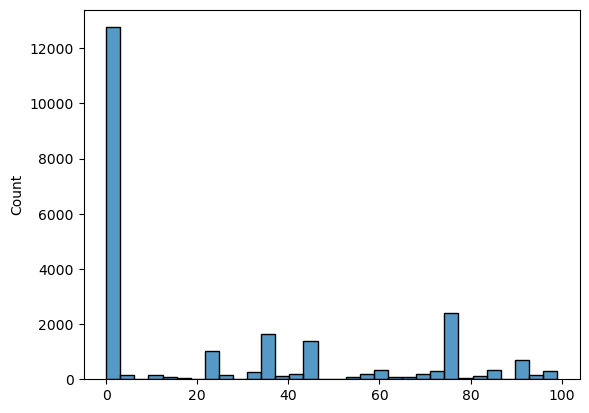

In [32]:
sns.histplot(data=pred)

In [76]:
def recover_from_cluster_scatter(raw_pred, cluster_model, nz_index, n_targets, batch_size):
    # raw_pred: prediction for those clusters, say 100 clusters, then 100 predictions (for one observation)
    # cluster_model: the model used for clustering
    # nz_index: the index for all non-zero values (columns)
    # n_targets: how many targets in total
    # batch_size: number of observations
    pred = np.zeros(n_targets)
    n_y = cluster_model.n_clusters # how many clusters do we have
    for i_y in range(n_y):          # i_y is the index for clusters
        i_nz = np.where(cluster_model.labels_==i_y)    #i_nz is the index (in the nonzero items) where the item belongs to cluster i_y
        pred[nz_index[i_nz]] = raw_pred[i_y]    # nz_index[i_nz] is the index (in the full prediction) where the item belongs to cluster i_y
    return pred

In [36]:
pred = recover_from_cluster_scatter(range(100,200), km, nz_index, 23418)

In [37]:
pred

array([177., 177., 177., ..., 145., 124., 165.])

In [101]:
def recover_from_cluster(raw_pred, cluster_model, nz_index, n_targets, batch_size):
    # raw_pred: prediction for those clusters, size: batch_size*raw_pred
    # cluster_model: the model used for clustering
    # nz_index: the index for all non-zero values (columns), size: number of non-zero columns
    # n_targets: how many targets in total
    # batch_size: number of observations (rows)
    pred = np.zeros([batch_size, n_targets])
    n_y = cluster_model.n_clusters # how many clusters do we have
    for i_y in range(n_y):          # i_y is the index for clusters
        i_nz = np.where(cluster_model.labels_==i_y)    #i_nz is the index (in the nonzero items) where the item belongs to cluster i_y
        pred[:,nz_index[i_nz]] = np.tile(raw_pred[:,i_y],[1,len(i_nz)]).T    # nz_index[i_nz] is the index (in the full prediction) where the item belongs to cluster i_y
    return pred

In [104]:
n_r = 5     # rows
n_t = 10    # targets
n_cl = 3    # clusters
nz_test = np.array([0,2,4,6,8]) # index of elements that are non-zero in targets
Y = np.random.randint(0,10, (n_r, len(nz_test)))
y = np.tile(range(1, n_cl+1), [n_r,1]) # generate raw predictions of number of clusters

In [105]:
y

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [106]:
km_test = KMeans(n_clusters=n_cl)
km_test.fit(Y.T)

KMeans(n_clusters=3)

In [107]:
km_test.labels_

array([1, 2, 1, 0, 1])

In [108]:
pred = recover_from_cluster(y, km_test, nz_test, n_t, n_r)

In [109]:
pred

array([[2., 0., 3., 0., 2., 0., 1., 0., 2., 0.],
       [2., 0., 3., 0., 2., 0., 1., 0., 2., 0.],
       [2., 0., 3., 0., 2., 0., 1., 0., 2., 0.],
       [2., 0., 3., 0., 2., 0., 1., 0., 2., 0.],
       [2., 0., 3., 0., 2., 0., 1., 0., 2., 0.]])

In [86]:
np.zeros([2,4])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])